# Data

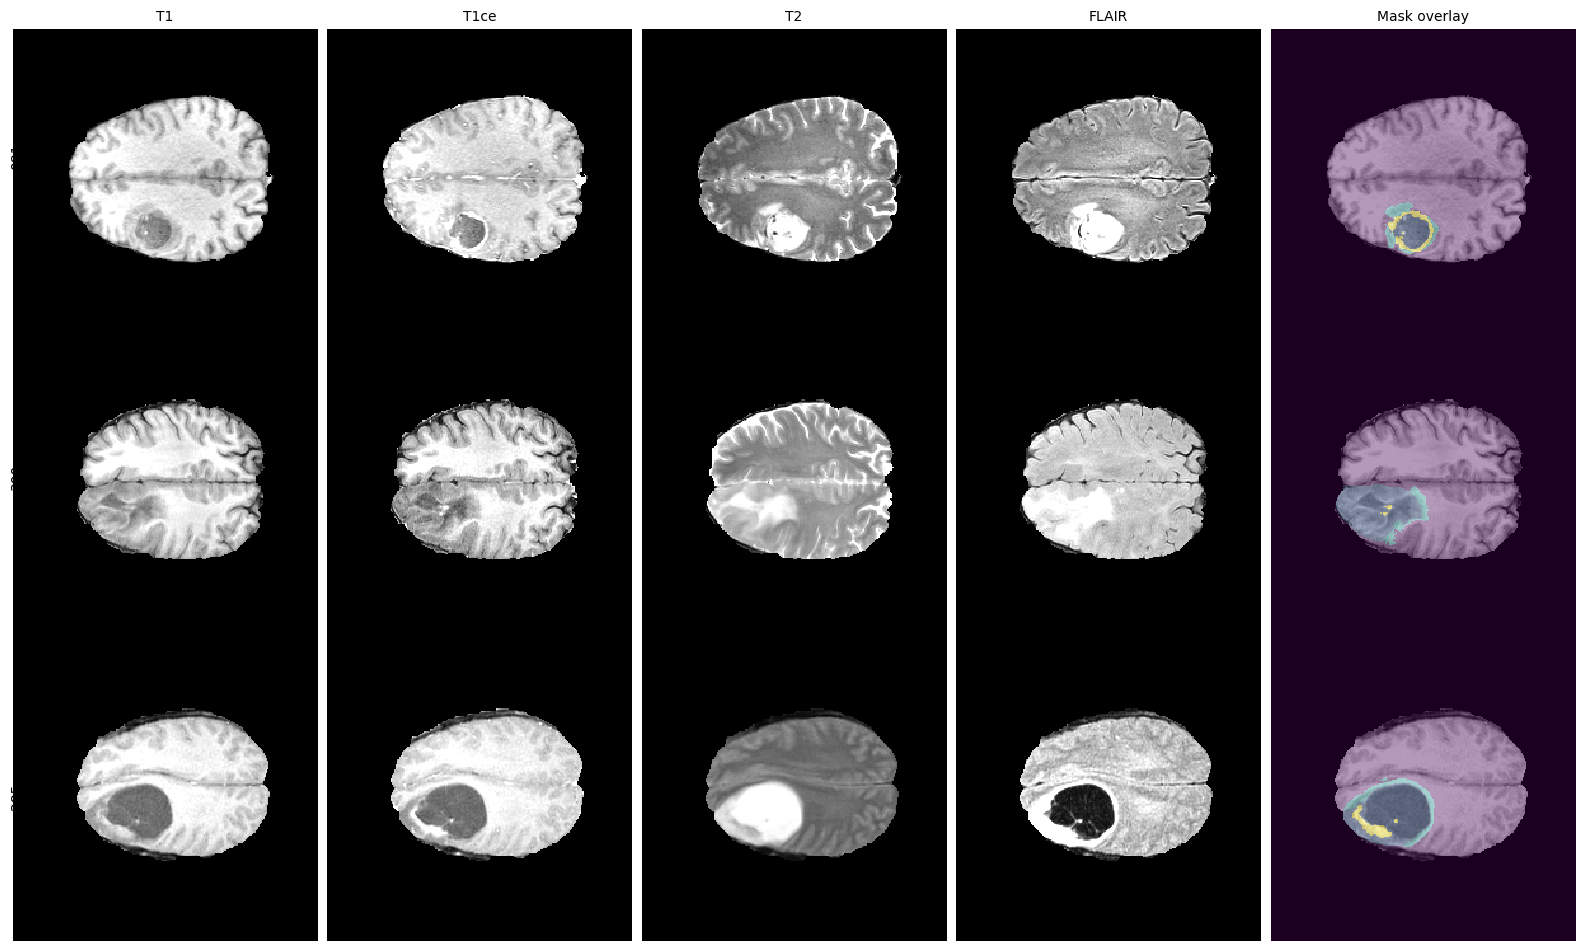

In [1]:
from pathlib import Path
from typing import Dict, List, Tuple
import random
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset

# ---- Config ----
DATA_ROOT = Path("/kaggle/input/train-data")   # adjust if Kaggle renamed it
SHOW_N_CASES = 3
CHANNEL_NAMES = ("T1", "T1ce", "T2", "FLAIR")
FILENAME_TOKENS: Dict[str, List[str]] = {
    "t1":    ["_t1."],
    "t1ce":  ["_t1ce."],
    "t2":    ["_t2."],
    "flair": ["_flair."],
    "mask":  ["_seg.", "_mask."],
}

# ---- Utils ----
def _assert_dataset(path: Path) -> None:
    if not path.exists():
        raise FileNotFoundError(f"Not found: {path} (add dataset via '+ Add Data').")

def _pick_case_dirs(root: Path) -> List[Path]:
    return sorted([p for p in root.iterdir() if p.is_dir()])

def _locate_modality(case_dir: Path, needles: List[str]) -> Path:
    for f in case_dir.iterdir():
        n = f.name.lower()
        if (n.endswith(".nii") or n.endswith(".nii.gz")) and any(tok in n for tok in needles):
            return f
    raise FileNotFoundError(f"Missing in {case_dir}: {needles}")

def minmax_01(v: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    vmin, vmax = np.nanmin(v), np.nanmax(v)
    return (v - vmin) / (vmax - vmin + eps)

def clip_percentile_01(x: np.ndarray, lo: float = 2, hi: float = 98, eps: float = 1e-6) -> np.ndarray:
    finite = np.isfinite(x)
    p_lo, p_hi = np.percentile(x[finite], [lo, hi])
    x = np.clip(x, p_lo, p_hi)
    return (x - p_lo) / (p_hi - p_lo + eps)

# ---- Dataset ----
class BraTS2DMidSlice(Dataset):
    """Returns (img[4,H,W] in [0,1], mask[H,W]); mask binarized if >0."""
    def __init__(self, case_dirs: List[Path], binarize: bool = True, transform=None):
        self.cases = case_dirs
        self.binarize = binarize
        self.transform = transform

    def __len__(self) -> int:
        return len(self.cases)

    def _paths_for(self, case_dir: Path) -> Tuple[Path, Path, Path, Path, Path]:
        return (
            _locate_modality(case_dir, FILENAME_TOKENS["t1"]),
            _locate_modality(case_dir, FILENAME_TOKENS["t1ce"]),
            _locate_modality(case_dir, FILENAME_TOKENS["t2"]),
            _locate_modality(case_dir, FILENAME_TOKENS["flair"]),
            _locate_modality(case_dir, FILENAME_TOKENS["mask"]),
        )

    def __getitem__(self, i: int):
        t1_p, t1ce_p, t2_p, flair_p, mask_p = self._paths_for(self.cases[i])
        vols = [nib.load(str(p)).get_fdata().astype(np.float32) for p in (t1_p, t1ce_p, t2_p, flair_p)]
        lab3d = nib.load(str(mask_p)).get_fdata()
        vols = [minmax_01(v) for v in vols]
        mid = vols[0].shape[2] // 2
        img = np.stack([v[:, :, mid] for v in vols], axis=0)
        msk = lab3d[:, :, mid]
        msk = (msk > 0).astype(np.float32) if self.binarize else msk.astype(np.int16)
        if self.transform: img, msk = self.transform(img, msk)
        return torch.from_numpy(img).float(), torch.from_numpy(msk).float()

# ---- Preview ----
def preview_random_cases(case_dirs: List[Path], n: int = 3, titles=CHANNEL_NAMES) -> None:
    n = max(1, min(n, len(case_dirs)))
    picks = random.sample(case_dirs, k=n)

    fig, axes = plt.subplots(n, 5, figsize=(5 * 3.2, n * 3.2))
    if n == 1: axes = np.expand_dims(axes, 0)

    for i, case_dir in enumerate(picks):
        t1_p   = _locate_modality(case_dir, FILENAME_TOKENS["t1"])
        t1ce_p = _locate_modality(case_dir, FILENAME_TOKENS["t1ce"])
        t2_p   = _locate_modality(case_dir, FILENAME_TOKENS["t2"])
        fl_p   = _locate_modality(case_dir, FILENAME_TOKENS["flair"])
        m_p    = _locate_modality(case_dir, FILENAME_TOKENS["mask"])

        vols = [nib.load(str(p)).get_fdata() for p in (t1_p, t1ce_p, t2_p, fl_p)]
        lab  = nib.load(str(m_p)).get_fdata()
        mid  = vols[0].shape[2] // 2

        vis_imgs = [clip_percentile_01(v[:, :, mid]) for v in vols]
        vis_mask = lab[:, :, mid]

        fig.text(0.01, 1 - (i + 0.5) / n, case_dir.name,
                 rotation=90, va="center", ha="left", fontsize=10)

        # 4 modality panels
        for c in range(4):
            ax = axes[i, c]
            ax.imshow(vis_imgs[c], cmap="gray", interpolation="nearest")
            if i == 0: ax.set_title(titles[c], fontsize=10)
            ax.axis("off")

        ax = axes[i, 4]
        ax.imshow(vis_imgs[0], cmap='gray', interpolation='nearest')      
        ax.imshow(vis_mask, cmap='viridis', alpha=0.4, interpolation='nearest')  
        if i == 0: ax.set_title("Mask overlay", fontsize=10)
        ax.axis("off")

    plt.tight_layout(w_pad=0.2, h_pad=0.2)
    plt.show()

# ---- Run ----
_assert_dataset(DATA_ROOT)
CASE_DIRS = _pick_case_dirs(DATA_ROOT)
if not CASE_DIRS:
    raise RuntimeError(f"No case folders under: {DATA_ROOT}")

ds = BraTS2DMidSlice(CASE_DIRS, binarize=True, transform=None)
preview_random_cases(CASE_DIRS, n=SHOW_N_CASES)


# Training

In [2]:
# === DATALOADERS ===
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_dirs, val_dirs = train_test_split(CASE_DIRS, test_size=0.2, random_state=42)

train_dataset = BraTS2DMidSlice(train_dirs, binarize=True, transform=None)
val_dataset   = BraTS2DMidSlice(val_dirs,   binarize=True, transform=None)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2, pin_memory=True)


In [3]:
# === MODEL CLASS ===
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple, List

class UNet(nn.Module):
    """Tiny UNet-ish head producing per-pixel class probabilities."""
    def __init__(self, in_channels: int = 4, out_classes: int = 2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, out_classes, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return F.softmax(x, dim=1)  # [B,K,H,W]

class DeepSVGModel(nn.Module):
    """
    CNN + diagonal GMM, optimizes NLL (+ optional entropy + Dice).
    Assumes binary mask {0,1} (bg=0, tumor=1).
    """
    def __init__(self, in_channels: int = 4, num_classes: int = 2, device: str = "cuda"):
        super().__init__()
        assert num_classes == 2, "This setup assumes binary GT."
        self.net = UNet(in_channels=in_channels, out_classes=num_classes)
        self.num_classes = num_classes
        self.mu: Optional[torch.Tensor] = None     
        self.sigma: Optional[torch.Tensor] = None 
        self.pi: Optional[torch.Tensor] = None     
        self.device = torch.device(device)

    # --- GMM init/M-step ---
    def _init_gmm(self, C: int) -> None:
        K = self.num_classes
        self.mu    = torch.randn(K, C, device=self.device)
        self.sigma = torch.ones(K, C, device=self.device)
        self.pi    = torch.ones(K,    device=self.device) / K

    @torch.no_grad()
    def m_step(self, image: torch.Tensor, w: torch.Tensor) -> None:
        B, C, H, W = image.shape
        K = w.shape[1]
        img   = image.permute(0,2,3,1).reshape(-1, C)   
        wflat = w.permute(0,2,3,1).reshape(-1, K)      
        Nk = torch.sum(wflat, dim=0) + 1e-8             
        mu = (wflat.T @ img) / Nk.unsqueeze(1)          
        diff  = img.unsqueeze(1) - mu.unsqueeze(0)    
        sigma = (wflat.unsqueeze(2) * diff**2).sum(0) / Nk.unsqueeze(1)  
        pi    = Nk / torch.sum(Nk)
        self.mu, self.sigma, self.pi = mu, sigma, pi

    # --- Losses ---
    def nll_loss(self, image: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        assert self.mu is not None and self.sigma is not None, "Init GMM first."
        B, C, H, W = image.shape
        K = self.mu.shape[0]
        img   = image.permute(0,2,3,1).reshape(-1, C)  
        wflat = w.permute(0,2,3,1).reshape(-1, K)      

        ll = []
        for k in range(K):
            diff = img - self.mu[k]
            logp = -0.5 * torch.sum(diff**2 / (self.sigma[k] + 1e-8), dim=1)
            logp += -0.5 * torch.sum(torch.log(self.sigma[k] + 1e-8))
            ll.append(logp)
        ll = torch.stack(ll, dim=1)                    

        log_sum = torch.logsumexp(torch.log(wflat + 1e-8) + ll, dim=1)
        return -log_sum.mean()

    @staticmethod
    def entropy_loss(w: torch.Tensor) -> torch.Tensor:
        return -torch.mean(torch.sum(w * torch.log(w + 1e-8), dim=1))

    @staticmethod
    def dice_loss_soft_binary(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        intersection = (pred * target).sum(dim=(1,2))
        union = pred.sum(dim=(1,2)) + target.sum(dim=(1,2))
        dice = (2*intersection + eps) / (union + eps)
        return 1 - dice.mean()

    # --- API ---
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

    def compute_loss(
        self,
        images: torch.Tensor,
        masks: torch.Tensor,
        lambda_entropy: float = 0.1,
        lambda_dice: float = 4.0,
        tumor_class: int = 1,
    ) -> Tuple[torch.Tensor, dict]:
        images = images.to(self.device)
        masks  = masks.to(self.device)
        w = self.forward(images)

        if self.mu is None:
            self._init_gmm(C=images.shape[1])

        loss = self.nll_loss(images, w)
        logs = {"nll": float(loss.detach().cpu())}

        if lambda_entropy > 0:
            ent = self.entropy_loss(w)
            loss = loss + lambda_entropy * ent
            logs["entropy"] = float(ent.detach().cpu())

        if lambda_dice > 0 and self.num_classes > 1:
            tumor_pred = w[:, tumor_class, :, :]
            dloss = self.dice_loss_soft_binary(tumor_pred, masks)
            loss = loss + lambda_dice * dloss
            logs["dice"] = float(dloss.detach().cpu())

        return loss, logs

    @torch.no_grad()
    def predict_argmax(self, image: torch.Tensor) -> torch.Tensor:
        self.eval()
        w = self.forward(image.unsqueeze(0).to(self.device))
        return torch.argmax(w, dim=1).squeeze(0).cpu()


In [4]:
# === TRAINING LOOP ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DeepSVGModel(in_channels=4, num_classes=2, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
LAMBDA_ENT = 0.1
LAMBDA_DICE = 4.0
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0

    for images, masks in train_loader:
        optimizer.zero_grad()

        loss, logs = model.compute_loss(
            images, masks,
            lambda_entropy=LAMBDA_ENT,
            lambda_dice=LAMBDA_DICE,
            tumor_class=1,
        )
        loss.backward()
        optimizer.step()

        # M-step: refresh GMM params using current soft assignments
        with torch.no_grad():
            w = model(images.to(model.device))
            model.m_step(images.to(model.device), w)

        running += float(loss.detach().cpu())

    avg = running / max(1, len(train_loader))
    history.append(avg)
    print(f"Epoch {epoch:03d} --- loss={avg:.4f}")


[Epoch 001] loss=-3.5133
[Epoch 002] loss=-3.0264
[Epoch 003] loss=-3.9877
[Epoch 004] loss=-3.1249
[Epoch 005] loss=-3.4138
[Epoch 006] loss=-3.1126
[Epoch 007] loss=-3.4667
[Epoch 008] loss=-3.0487
[Epoch 009] loss=-3.4355
[Epoch 010] loss=-3.0950
[Epoch 011] loss=-3.1322
[Epoch 012] loss=-3.1429
[Epoch 013] loss=-3.0388
[Epoch 014] loss=-3.0863
[Epoch 015] loss=-3.1937
[Epoch 016] loss=-3.0383
[Epoch 017] loss=-3.1701
[Epoch 018] loss=-3.0836
[Epoch 019] loss=-3.0042
[Epoch 020] loss=-3.0418
[Epoch 021] loss=-3.0955
[Epoch 022] loss=-2.9607
[Epoch 023] loss=-3.0830
[Epoch 024] loss=-2.9857
[Epoch 025] loss=-3.0790
[Epoch 026] loss=-2.9908
[Epoch 027] loss=-2.9703
[Epoch 028] loss=-3.0255
[Epoch 029] loss=-3.0659
[Epoch 030] loss=-3.0087
[Epoch 031] loss=-3.0916
[Epoch 032] loss=-3.0642
[Epoch 033] loss=-3.0466
[Epoch 034] loss=-3.0880
[Epoch 035] loss=-3.0576
[Epoch 036] loss=-3.0055
[Epoch 037] loss=-3.0161
[Epoch 038] loss=-2.9992
[Epoch 039] loss=-3.0260
[Epoch 040] loss=-3.0934


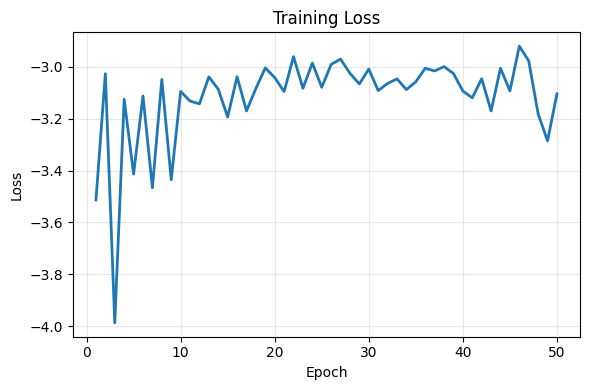

In [5]:
# === PLOT LOSSES ===
plt.figure(figsize=(6,4))
plt.plot(range(1, len(history)+1), history, linewidth=2)
plt.xlabel("Epoch");
plt.ylabel("Loss");
plt.title("Training Loss");
plt.grid(alpha=0.3)
plt.tight_layout();
plt.show()


# Results

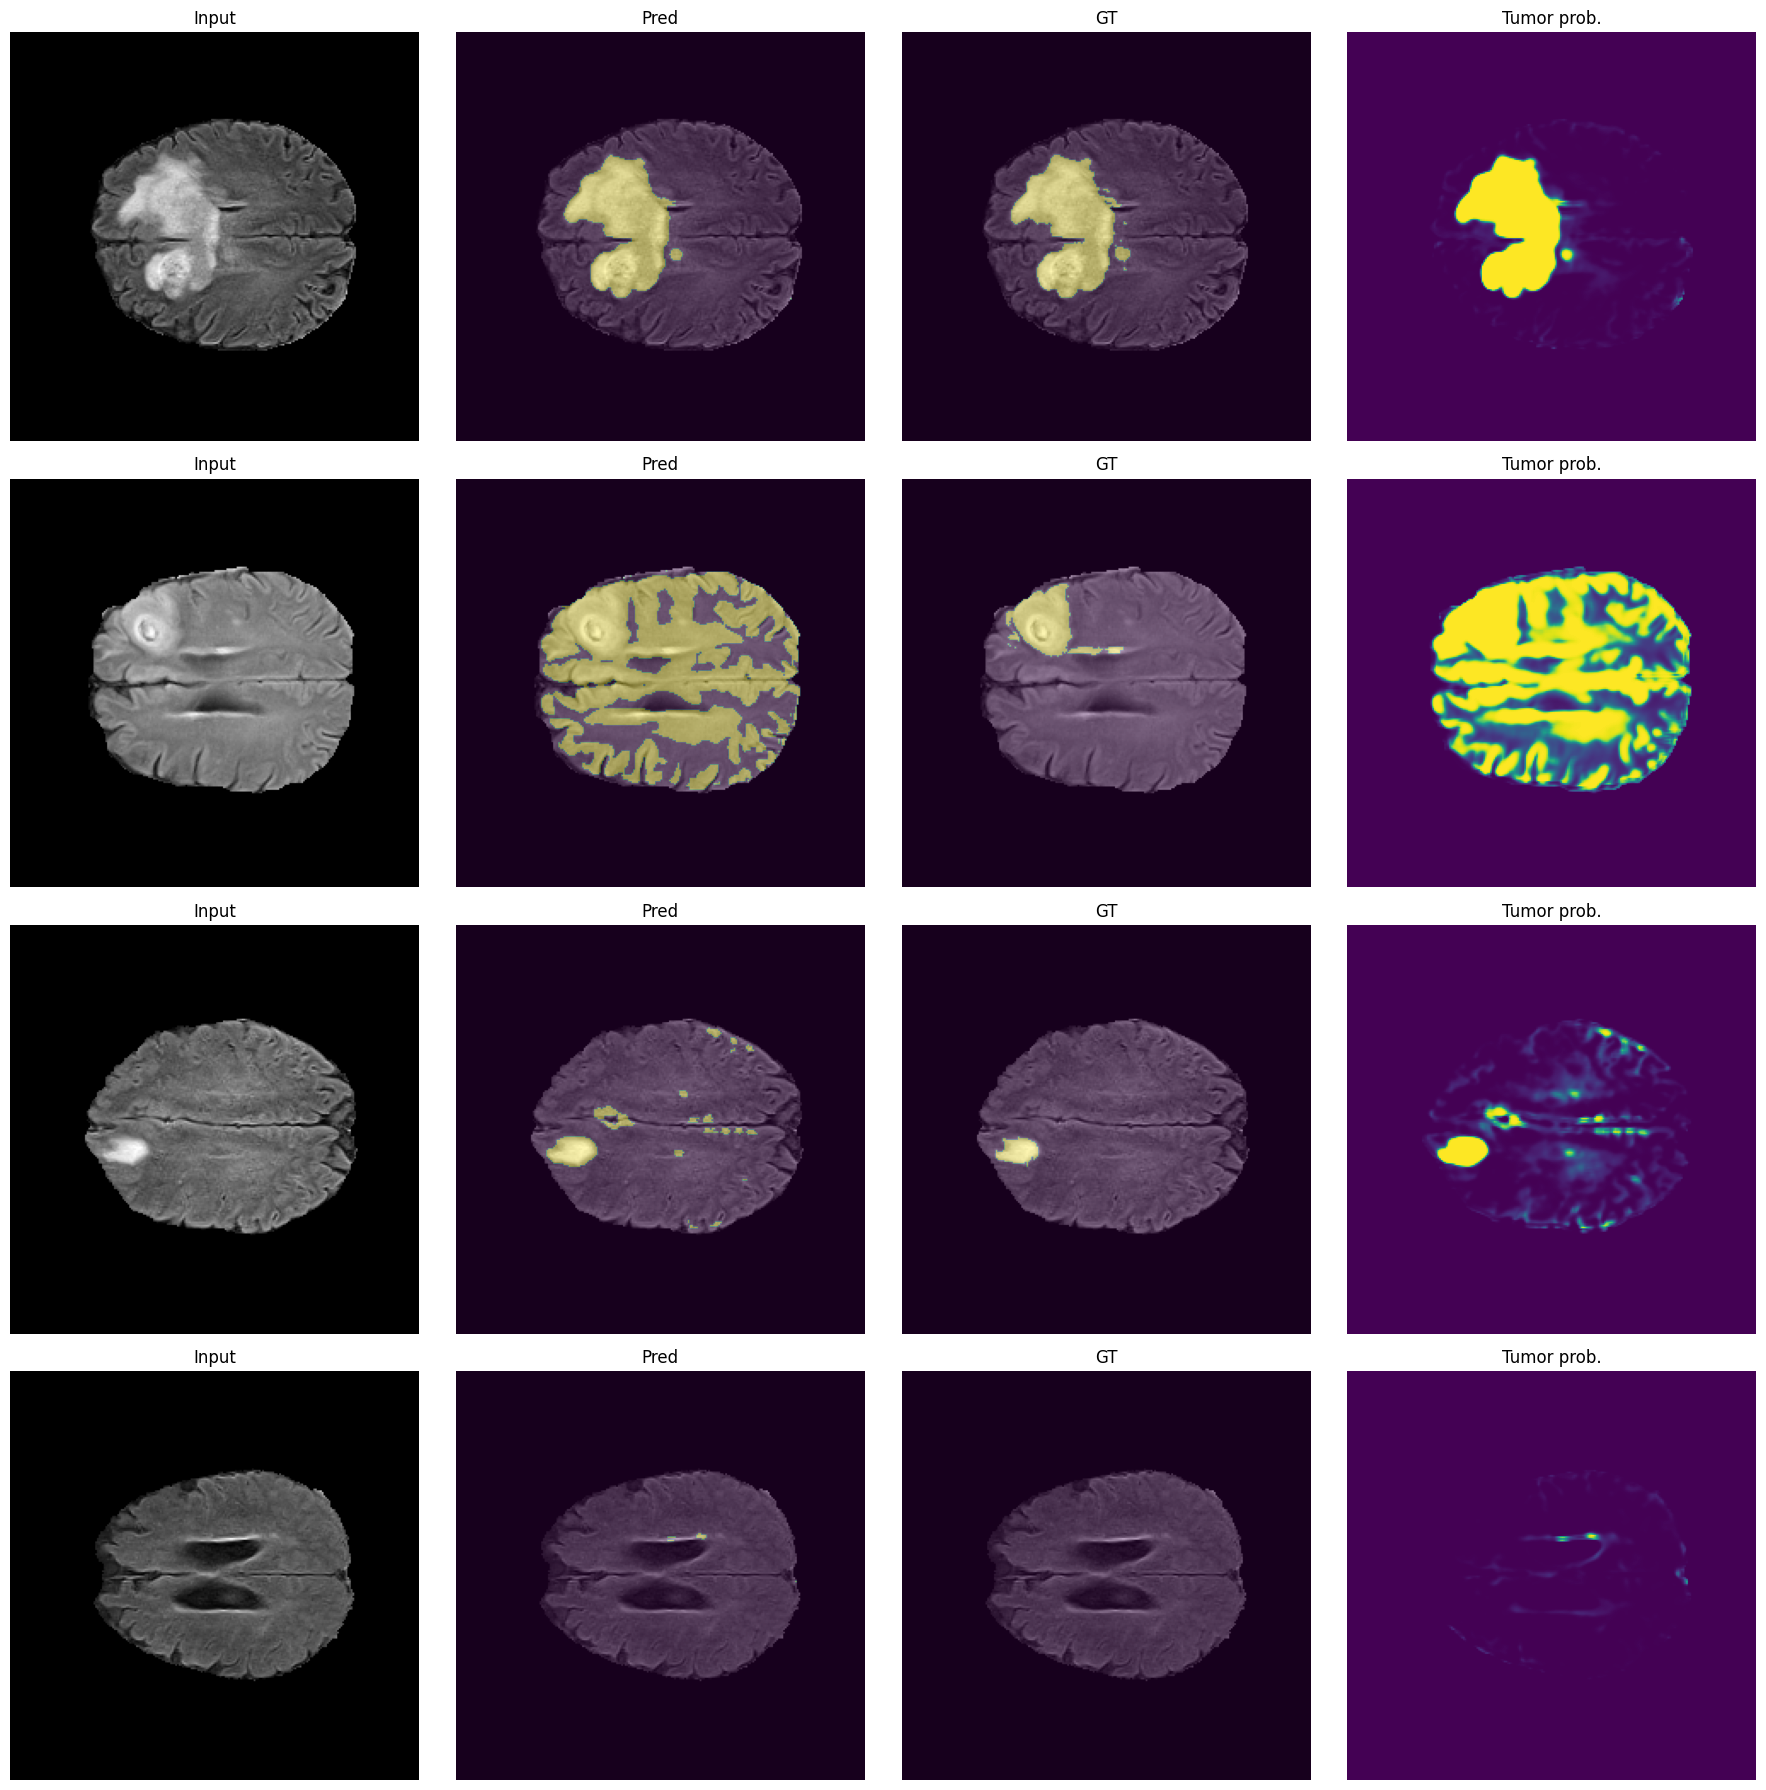

In [11]:
# === SAMPLE PLOTS ===
from typing import List, Optional

def show_samples(
    model: DeepSVGModel,
    dataset: BraTS2DMidSlice,
    indices: Optional[List[int]] = None,      
    vis_channel: int = 3,
    alpha: float = 0.35,
    extra: bool = False,                       
    num_random: int = 5,                   
):
    model.eval()

    if indices is None or (isinstance(indices, str) and indices.lower() == "random"):
        import random
        k = min(num_random, len(dataset))
        chosen = random.sample(range(len(dataset)), k=k)
    else:
        chosen = list(indices)

    rows = len(chosen)
    cols = 4 if extra else 3
    titles_basic = ["Input", "Pred", "GT"]
    titles_extra = titles_basic + ["Tumor prob.", "Uncertainty"]

    plt.figure(figsize=(cols * 4.5, rows * 4.5))

    for r, idx in enumerate(chosen):
        img, msk = dataset[idx]                                
        ch = max(0, min(vis_channel, img.shape[0]-1))
        base = img[ch].numpy()

        with torch.no_grad():
            probs = model.forward(img.unsqueeze(0).to(model.device)).squeeze(0).cpu()  
            pred_lbl = torch.argmax(probs, dim=0)                                      
        pred_bin = (pred_lbl.numpy() == 1).astype(float)
        gt_bin   = (msk.numpy()       == 1).astype(float)

        # --- basic 3 panels ---
        ax = plt.subplot(rows, cols, r*cols + 1)
        ax.imshow(base, cmap="gray"); 
        ax.set_title(titles_basic[0]); ax.axis("off")

        ax = plt.subplot(rows, cols, r*cols + 2)
        ax.imshow(base, cmap="gray"); ax.imshow(pred_bin, alpha=alpha)
        ax.set_title(titles_basic[1]); ax.axis("off")

        ax = plt.subplot(rows, cols, r*cols + 3)
        ax.imshow(base, cmap="gray"); ax.imshow(gt_bin, alpha=alpha)
        ax.set_title(titles_basic[2]); ax.axis("off")

        # --- optional extras ---
        if extra:
            tumor_prob = probs[1].numpy()  # class-1 probability map
            # pixel-wise uncertainty (Shannon entropy)
            w_np = probs.numpy()
            eps = 1e-8
            ent = -(w_np * np.log(w_np + eps)).sum(axis=0)

            ax = plt.subplot(rows, cols, r*cols + 4)
            im = ax.imshow(tumor_prob, cmap="viridis")
            ax.set_title(titles_extra[3]); ax.axis("off")

            # ax = plt.subplot(rows, cols, r*cols + 5)
            # im = ax.imshow(ent, cmap="magma")
            # ax.set_title(titles_extra[4]); ax.axis("off")

    plt.tight_layout(); plt.show()

show_samples(model, val_dataset, indices=None, vis_channel=3, alpha=0.35, extra=True, num_random=4)


# Experimental setup & model

We used the BraTS-style dataset with four MRI modalities (T1, T1ce, T2, FLAIR). For each case we extracted the axial mid-slice, min–max normalized each modality to \[0,1], and binarized the ground-truth mask (tumor vs. background). Data were split 80/20 into train/val. The segmentation network is a small UNet-like CNN that outputs per-pixel class probabilities (K=2). We coupled it with a diagonal-covariance Gaussian Mixture Model and trained using the deepSVG scheme: a gradient step minimizes the SVGMM negative log-likelihood (NLL) with optional entropy regularization and a supervised soft Dice term; then an M-step updates GMM parameters (means/variances/mix). We trained with Adam (lr=1e-3), batch size 8, for 50 epochs.

# Qualitative results & analysis

The visualizations show the model behaves as expected for a CNN+GMM prior: in slices with a large, high-contrast lesion, the predicted mask closely follows the ground truth and the tumor-probability map is bright and coherent over the lesion core (high confidence). In more heterogeneous cases, especially where edema texture resembles normal parenchyma, the model produces patchy false positives—consistent with a diagonal GMM relying mainly on per-pixel intensity cues. For slices with very small lesions, sensitivity drops and some small foci are under-segmented or missed; conversely, nearly negative slices exhibit low, diffuse probabilities with minimal false positives. Overall, the CNN’s spatial bias smooths predictions, but our 2D mid-slice setup (no 3D context), shallow backbone, and diagonal covariances limit boundary precision and encourage occasional speckling in regions with similar intensities. Likely improvements include sampling multiple slices per case (or 3D patches), stronger augmentations, variance clamping/post-processing (e.g., largest connected component), and/or a slightly deeper UNet or attention gates to better suppress texture-driven false positives.
